In [ ]:
############################################################################
#
#     This program is free software; you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation; either version 2, or (at your option)
#   any later version.
#
#   Notebook to implement the Machine Learning model with different
# algorithms.  
#
#   Author: Fernando Burrieza Galan
#
#   Version: 2.5
#
#   Since: 06/05/2022
#
###########################################################################

!pip install elasticsearch7==7.17.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 386 kB 5.4 MB/s 


# Libraries
This section covers the different libraries used in this project. The purpose of each one will be reflected during this notebook.

In [ ]:
# Import main Libraries for this notebook
import os
import sys
import time
import pip
import setuptools
import numpy as np
import pandas as pd
from numpy import array
from numpy import argmax
import seaborn as sn
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from elasticsearch7 import Elasticsearch
from elasticsearch7.helpers import scan

In [ ]:
# Upload Google Drive Files to the Notebook
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My Laptop/UC3M 1/4º Year/2º Four Month/TFG/DATA')

Mounted at /content/drive


# Elasticsearch Connection 

This section of the notebook connects Elasticsearch in order to retrieve the indexes of the network traffic in order to make the model.

In [ ]:
# Connect to my ElasticSearch Service
es = Elasticsearch("http://localhost:9200")
es.ping()

False

In [ ]:
# Extract the documents that each index has to convert into a Dataframe
def get_data_from_elastic(index_name):

    # Scan function to get all the data. 
    rel = scan(client=es,                                     
               scroll='1m',
               index=index_name,
               raise_on_error=True,
               preserve_order=False,
               clear_scroll=True)

    # Keep response in a list.
    result = list(rel)

    temp = []

    # We need only '_source', which has all the fields required.
    # This elimantes the elasticsearch metdata like _id, _type, _index.
    for hit in result:
        temp.append(hit['_source'])

    # Create a dataframe.
    df = pd.DataFrame(temp)

    return df

In [ ]:
#  Call to the previous function to obtanthe records of each index
conn_index = 'zeek_conn_2022-05-06'
dnp3_index = 'zeek_dnp3_2022-05-06'
packet_filter_index = 'zeek_packet_filter_2022-05-06'
weird_index = 'zeek_weird_2022-05-06'

conn_es_df = get_data_from_elastic(conn_index)
dnp3_es_df = get_data_from_elastic(dnp3_index)
packet_filter_es_df = get_data_from_elastic(packet_filter_index)
weird_es_df = get_data_from_elastic(weird_index)


# Data processing

This section will deal with the data with the purpose of normalization to create a better model.

## Covering datasets faults

Some datasets have errors in the process of converting to a csv file. This subsection transforms the dataframes to deal with data easily

### DNP3 Dataframe

#### INDEXING OPERATIONS TO INT

In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.fc_request = dnp3_df.fc_request.fillna('NO_OPERATION')

print("Number of Nan values (req):", dnp3_df['fc_request'].isna().sum(),'\n')

# ASSIGN THE CATEGORY TO fc_request
fc_request = dnp3_df['fc_request'].value_counts()
fc_request_cat = pd.DataFrame(fc_request)
fc_request_cat.reset_index(inplace=True)
fc_request_cat.columns = ['Operation', 'Count']
fc_request_cat = fc_request_cat.assign(Category = [1, 2, 3, 4, 5, 6, 7, 8, 9,  
                                                10, 11, 12, 13, 14, 15, 16, 17])
# Create a Dictionary with IP and Category
fc_request_serie = dict(zip(fc_request_cat.Operation, fc_request_cat.Category))

# Assign the new categories
dnp3_df['fc_request_index'] = dnp3_df['fc_request'].map(fc_request_serie)

dnp3_df

Number of Nan values (req): 0 



,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NaN,NaN,11,11,9
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,0,NaN,NaN,11,11,17
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NaN,NaN,11,11,1
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NaN,NaN,7,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NaN,NaN,4,4,1
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NaN,NaN,6,6,9


In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.fc_reply = dnp3_df.fc_reply.fillna('NO_OPERATION')

print("Number of Nan values (res):", dnp3_df['fc_reply'].isna().sum(),'\n')

# ASSIGN THE CATEGORY TO fc_request
fc_reply = dnp3_df['fc_reply'].value_counts()
fc_reply_cat = pd.DataFrame(fc_reply)
fc_reply_cat.reset_index(inplace=True)
fc_reply_cat.columns = ['Operation', 'Count']
fc_reply_cat = fc_reply_cat.assign(Category = [1, 2, 3, 4])
print(fc_reply_cat)
# Create a Dictionary with IP and Category
fc_reply_serie = dict(zip(fc_reply_cat.Operation, fc_reply_cat.Category))

# Assign the new categories
dnp3_df['fc_reply_index'] = dnp3_df['fc_reply'].map(fc_reply_serie)

dnp3_df

Number of Nan values (res): 0 

              Operation   Count  Category
0              RESPONSE  256478         1
1  UNSOLICITED_RESPONSE   26862         2
2          NO_OPERATION      22         3
3                  READ       4         4


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,11,11,9,3
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,0,NO_OPERATION,NaN,11,11,17,3
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,0,NO_OPERATION,NaN,11,11,1,3
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,0,RESPONSE,4096.0,12,12,1,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,0,NO_OPERATION,NaN,7,7,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,RESPONSE,0.0,4,4,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,0,NO_OPERATION,NaN,4,4,1,3
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,0,NO_OPERATION,NaN,6,6,9,3


In [ ]:
dnp3_df.to_csv('dnp3_df.csv', index = False)

#### Weird Log

In [ ]:
weird_df.drop(['zeek_log_filename', 'zeek_log_path', '@timestamp'], axis=1, inplace=True)

In [ ]:
print("Number of Nan values (Name):", weird_df['name'].isna().sum(),'\n\n')
print("Number of Nan values (source):", weird_df['source'].isna().sum(),'\n\n')
print("Number of Nan values (addl):", weird_df['addl'].isna().sum(),'\n\n')


print(weird_df['addl'].value_counts(), '\n')
print(weird_df['source'].value_counts(),'\n')
print(weird_df['name'].value_counts(),'\n')

weird_df = weird_df[weird_df.source =='DNP3_TCP']

Number of Nan values (Name): 0 


Number of Nan values (source): 282 


Number of Nan values (addl): 2212 


SSH-2.0-moxa_1.0 vs SSH-1.5-Nmap-SSH1-Hostkey       16
SSH-2.0-OpenSSH_4.0 vs SSH-1.5-Nmap-SSH1-Hostkey     8
SSH-2.0-OpenSSH_4.0 vs SSH-1.5-NmapNSE_1.0           8
SSH-2.0-Mocana SSH  vs SSH-1.5-Nmap-SSH1-Hostkey     8
SSH-2.0-Mocana SSH  vs SSH-1.5-NmapNSE_1.0           8
SSH-2.0-moxa_1.0 vs SSH-1.5-NmapNSE_1.0              8
t3                                                   3
SSH-2.0-moxa_1.0 vs HELP                             2
Name: addl, dtype: int64 

TCP            839
DNP3_TCP       588
HTTP           404
CONTENTLINE    157
NVT              3
Name: source, dtype: int64 

dnp3_header_lacks_magic           585
SYN_with_data                     402
bad_HTTP_request                  378
window_recision                   219
line_terminated_with_single_CR    157
TCP_ack_underflow_or_misorder     118
TCP_seq_underflow_or_misorder      70
active_connection_reuse           

#### Add anomaly values to DNP3_df

In [ ]:
# Extract the number of coincidences between the values of 2 columns
test_weird = weird_df['uid'].tolist()

test_dnp3 = dnp3_df['uid'].tolist()

results = {}

# Check number of occurrences that share both columns

for i in test_weird:
  results[i] = test_dnp3.count(i)


In [ ]:
# Iterate through this dict to eliminate all uid that don't match with dnp3
results = list(results.items())

results = [i for i in results if i[1] != 0]

results

[('CD36SZ6bAMITPqyHb', 1),
 ('CGEaHN1TGiFTDT1qy2', 12),
 ('Cw2ml51GVqvAUPZ9y1', 8),
 ('CEFe754uJcD8GlFhqa', 8),
 ('CMyQRm2pi6APKUWSK6', 8),
 ('CIavEB11ucm8caBQZ9', 8),
 ('CsIEa54EnLtNEAw29i', 8),
 ('Cp4LMT1TMgS8taDswe', 13),
 ('CZxrYyg421iFGjBn1', 3),
 ('CPuUCy3hKm6Ao7MA8f', 1),
 ('CMNEme4g5lqDQ5ltGh', 3),
 ('CEqxQV26A8OF11fsI2', 1)]

In [ ]:
# Assign the uid from result list to add the anomaly number

result = dict(results)
# Change the value for each key 
for key, value in result.items():
        result[key] = 1
result
# Assign the new categories
dnp3_df['anomaly'] = dnp3_df['uid'].map(result)
dnp3_df 

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,fc_request,anomaly,fc_reply,iin,id.orig_h_index,id.resp_h_index,fc_request_index,fc_reply_index
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,2127,192.168.88.95,20000,DISABLE_UNSOLICITED,NaN,NO_OPERATION,NaN,11,11,9,3
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,2137,192.168.88.95,20000,UNSOLICITED_RESPONSE,1.0,NO_OPERATION,NaN,11,11,17,3
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,2142,192.168.88.95,20000,READ,NaN,NO_OPERATION,NaN,11,11,1,3
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,20001,192.168.10.2,20000,READ,NaN,RESPONSE,4096.0,12,12,1,1
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,64825,127.0.0.1,20000,OPERATE,NaN,NO_OPERATION,NaN,7,7,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283361,2022-04-12T08:20:09.750000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,NaN,RESPONSE,0.0,4,4,1,1
283362,2022-04-12T08:20:10.250000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,NaN,RESPONSE,0.0,4,4,1,1
283363,2022-04-12T08:20:10.500000,CncY3T2Ec0zzUyBMha,192.168.1.150,53463,192.168.1.200,20000,READ,NaN,NO_OPERATION,NaN,4,4,1,3
283364,2022-04-12T08:18:58.500000,Cd0wDx1AnRKcD0oXae,10.0.0.8,1159,10.0.0.3,20000,DISABLE_UNSOLICITED,NaN,NO_OPERATION,NaN,6,6,9,3


In [ ]:
dnp3_df = dnp3_df.fillna({'anomaly': 0})

dnp3_df['anomaly'] = dnp3_df['anomaly'].astype(int)
print(dnp3_df['anomaly'].value_counts())

0    283292
1        74
Name: anomaly, dtype: int64


# Extract Features

In [ ]:
dnp3_df

,ts,uid,id.orig_h,id.orig_h_index,id.orig_p,id.resp_h,id.resp_h_index,id.resp_p,fc_request,fc_request_index,fc_reply,fc_reply_index,weird_type,weird_type_index,iin,anomaly
0,2022-04-16T02:52:21.375539,CDPLXV1J6t2QLI3Gg1,192.168.2.166,11,2127,192.168.88.95,11,20000,DISABLE_UNSOLICITED,9,NO_OPERATION,3,no_weird,1,NaN,0
1,2022-04-16T02:53:03.740016,CD36SZ6bAMITPqyHb,192.168.2.166,11,2137,192.168.88.95,11,20000,UNSOLICITED_RESPONSE,17,NO_OPERATION,3,dnp3_unexpected_flow_direction,2,NaN,1
2,2022-04-16T02:54:16.003435,C8RaC12ZzQoXAy9hr3,192.168.2.166,11,2142,192.168.88.95,11,20000,READ,1,NO_OPERATION,3,no_weird,1,NaN,0
3,2022-04-16T03:00:00.250000,CPE44L3WaZNQ5O4V1f,10.64.96.104,12,20001,192.168.10.2,12,20000,READ,1,RESPONSE,1,no_weird,1,4096.0,0
4,2022-04-16T03:00:15.750000,CB3VDD2kZBblvvf5k7,127.0.0.1,7,64825,127.0.0.1,7,20000,OPERATE,8,NO_OPERATION,3,no_weird,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374537,2022-04-16T17:26:56.478133,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,READ,1,RESPONSE,1,no_weird,1,0.0,1
374538,2022-04-16T17:26:56.703135,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,CONFIRM,3,UNSOLICITED_RESPONSE,2,no_weird,1,0.0,1
374539,2022-04-16T17:26:56.913136,CJBUEB34Fll3IfmsZe,192.168.10.66,13,37154,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,no_weird,1,0.0,1
374540,2022-04-16T17:33:56.271069,Clo3Nnt8Ore0B8h6c,192.168.10.221,1,51327,192.168.10.222,1,20000,NO_OPERATION,2,UNSOLICITED_RESPONSE,2,no_weird,1,0.0,1


In [ ]:
# Assign a value to NaN values on fc_request
dnp3_df.iin = dnp3_df.iin.fillna('null')

print("Number of Nan values (iin):", dnp3_df['iin'].isna().sum(),'\n')
print(dnp3_df['iin'].value_counts())
# ASSIGN THE CATEGORY TO fc_request
fc_request = dnp3_df['iin'].value_counts()
fc_request_cat = pd.DataFrame(fc_request)
fc_request_cat.reset_index(inplace=True)
fc_request_cat.columns = ['Size', 'Count']
fc_request_cat = fc_request_cat.assign(Category = [1, 2, 3, 4, 5, 6, 7, 8, 9,  
                                                10, 11, 12, 13, 14, 15, 16, 17,
                                                18, 19, 20, 21, 22, 23, 24, 25,
                                                26, 27, 28, 29])
# Create a Dictionary with IP and Category
fc_request_serie = dict(zip(fc_request_cat.Size, fc_request_cat.Category))

# Assign the new categories
dnp3_df['iin_index'] = dnp3_df['iin'].map(fc_request_serie)

Number of Nan values (iin): 0 

0.0        317141
4.0         13792
4096.0      11031
1024.0      10831
1540.0       5137
1536.0       4428
4097.0       2874
4100.0       2870
1028.0       2504
516.0        1339
512.0        1281
6144.0        624
null          533
32768.0        52
6145.0         30
6148.0         30
1.0            13
36864.0         6
8192.0          6
6.0             5
33792.0         2
15364.0         2
38145.0         2
256.0           2
15362.0         2
33280.0         2
38912.0         1
34304.0         1
38920.0         1
Name: iin, dtype: int64


In [ ]:
# Change order columns and store in csv
dnp3_df = dnp3_df[['ts','uid','id.orig_h','id.orig_h_index', 'id.orig_p', 'id.resp_h', 'id.resp_h_index', 'id.resp_p', 'fc_request', 'fc_request_index', 'fc_reply', 'fc_reply_index', 'weird_type', 'weird_type_index', 'iin', 'iin_index', 'anomaly']]
dnp3_df.to_csv('dnp3_df.csv', index=False)

# Evaluation of Machine Leanring Algorithms


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


# Para realizar una comparativa de modelos, tenemos que realizar una division de entrenamiento-validacion y test.
# Antes de realizar la división, crearemos un "diccionario" para guardar los modelos con los que vamos a trabajar

classifiers = { 
    'DecTree' : (DecisionTreeClassifier, {
        'criterion' : ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'random_state' : [0],
    } ),
    'RandForest' : (RandomForestClassifier, {
        'criterion' : ['gini', 'entropy', 'log_loss'],
        'random_state' : [0],
        'max_depth' : [5, 7]
    } ),
    'MLP' : (MLPClassifier, {
        'hidden_layer_sizes' : [(128,), (64,64), (64, 32, 16)],
        'activation': ['relu', 'tanh'],
    }),    
    'KNN' : (KNeighborsClassifier, {
        'n_neighbors' : [6, 7],
        'p' : [1, 2, 3],
    } ),
    'SVC' : (SVC, {
        'kernel' : ['sigmoid'],
        'gamma' : ['auto'],
        'random_state' : [0],
    } ),
}

In [ ]:
import itertools
from sklearn.model_selection import KFold

X = dnp3_features
y = dnp3_df['anomaly']

# Instanciamos una clase para hacer validación cruzada con 5 hojas
Xv, yv = X.values, y.values
cv = KFold(n_splits = 5, shuffle=True)

# Inicializamos una lista vacía para almacenar los resultados
results = []

# Iteramos por los distintos clasificadores
for clf_name, clf_info in classifiers.items():
  clf_class, clf_hyperparams = clf_info  
  hyp_ks, hyp_vs = clf_hyperparams.keys(), clf_hyperparams.values()
  configs = [dict(zip(hyp_ks, v)) for v in itertools.product(*hyp_vs)]

  # Iteramos por las distintas configuraciones de hiperparámetros
  for config in configs:
    print(config)
    # Instanciamos el clasificador con los hiperparámetros escogidos
    try:
      clf = clf_class(**config)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      confmat = metrics.confusion_matrix(y_test, y_pred)
      results.append({
          'Classifier': clf_name,
          'Hyperparameter' : str(config),
          'Accuracy' : metrics.accuracy_score(y_test, y_pred),
          'Precision' : metrics.precision_score(y_test, y_pred),
          'Recall' : metrics.recall_score(y_test, y_pred),
          'FPR' : (confmat[0,1] / (confmat[0,1] + confmat[0,0])),
          'F1' : metrics.f1_score(y_test, y_pred, average='binary'),
      })
    except Exception as e:
      pass

{'n_neighbors': 6, 'p': 1}
{'n_neighbors': 6, 'p': 2}
{'n_neighbors': 6, 'p': 3}
{'n_neighbors': 7, 'p': 1}
{'n_neighbors': 7, 'p': 2}
{'n_neighbors': 7, 'p': 3}
{'kernel': 'sigmoid', 'gamma': 'auto', 'random_state': 0}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_model = pd.DataFrame(results)
results_model.to_csv("results_model.csv", index=False)

## Evaluation of Results

In [ ]:
results_model = pd.read_csv('results_model.csv')
results_model

,Classifier,Hyperparameter,Accuracy,Precision,Recall,FPR,F1
0,DecTree,"{'criterion': 'gini', 'splitter': 'best', 'ran...",0.959177,0.891439,0.945686,0.036542,0.917762
1,DecTree,"{'criterion': 'gini', 'splitter': 'random', 'r...",0.959168,0.891408,0.945686,0.036554,0.917745
2,DecTree,"{'criterion': 'entropy', 'splitter': 'best', '...",0.959177,0.891439,0.945686,0.036542,0.917762
3,DecTree,"{'criterion': 'entropy', 'splitter': 'random',...",0.959177,0.891439,0.945686,0.036542,0.917762
4,RandForest,"{'criterion': 'gini', 'random_state': 0, 'max_...",0.959177,0.891439,0.945686,0.036542,0.917762
5,RandForest,"{'criterion': 'entropy', 'random_state': 0, 'm...",0.959177,0.891439,0.945686,0.036542,0.917762
6,MLP,"{'hidden_layer_sizes': (128,), 'activation': '...",0.959168,0.891408,0.945686,0.036554,0.917745
7,MLP,"{'hidden_layer_sizes': (128,), 'activation': '...",0.959132,0.891366,0.945575,0.036566,0.917671
8,MLP,"{'hidden_layer_sizes': (64, 64), 'activation':...",0.958216,0.888099,0.945686,0.037809,0.915988
9,MLP,"{'hidden_layer_sizes': (64, 64), 'activation':...",0.959177,0.891439,0.945686,0.036542,0.917762


In [ ]:
# Build a multi bar chart about Decision Tree
# It will represent the value of each metric.
new_df = pd.DataFrame()
new_df = results_model.iloc[[2, 5, 9, 10, 19, 12]]

In [ ]:
new_df.reset_index(inplace = True, drop = True)
new_df

,Classifier,Hyperparameter,Accuracy,Precision,Recall,FPR,F1
0,DecTree,"{'criterion': 'entropy', 'splitter': 'best', '...",0.959177,0.891439,0.945686,0.036542,0.917762
1,RandForest,"{'criterion': 'entropy', 'random_state': 0, 'm...",0.959177,0.891439,0.945686,0.036542,0.917762
2,MLP,"{'hidden_layer_sizes': (64, 64), 'activation':...",0.959177,0.891439,0.945686,0.036542,0.917762
3,MLP,"{'hidden_layer_sizes': (64, 32, 16), 'activati...",0.959177,0.891439,0.945686,0.036542,0.917762
4,KNN,"{'n_neighbors': 6, 'p': 2}",0.959159,0.891432,0.945612,0.036542,0.917723
5,SVC,"{'kernel': 'rbf', 'gamma': 'scale', 'random_st...",0.959168,0.891408,0.945686,0.036554,0.917745


## Evaluation Graph

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container0' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container1' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container2' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container3' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_container4' which cannot be automatically a

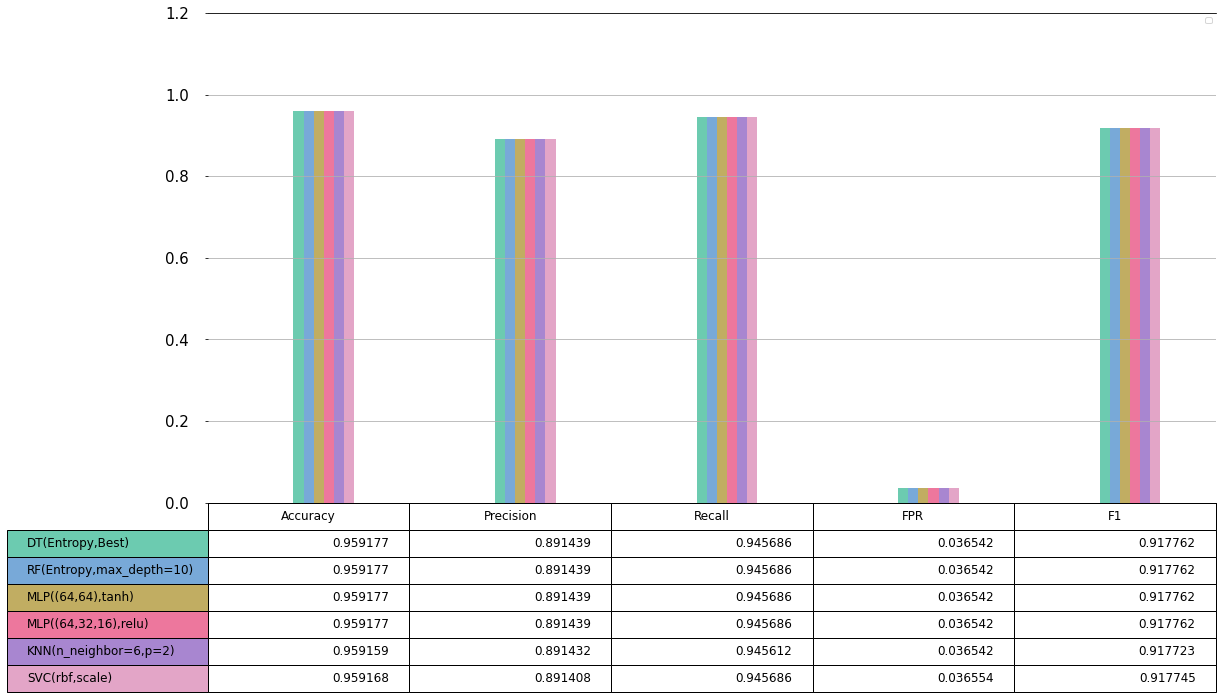

In [ ]:
# Implementation of matplotlib function
import numpy as np
import matplotlib.pyplot as plt

#define figure size in (width, height) for all plots
#plt.rcParams['figure.figsize'] = [10, 7]
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def plot_bar(dataset):
    matplotlib.rc('font', family='sans-serif')
    matplotlib.rc('font', serif='Helvetica Neue')
    matplotlib.rc('text', usetex='false')
    matplotlib.rcParams.update({'font.size': 8})
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(20,10)
    N = len(dataset[1])

    Load    = dataset[0]
    DT     = dataset[1]
    RF  = dataset[2]
    MLP = dataset[3]
    MLP1 = dataset[4]
    KNN = dataset[5]
    SVC = dataset[6]

    ind = np.arange(N)
    width = 0.05
    spare_width = (1 - width*2)/2


    plt.tick_params(axis='both', which='major', labelsize=15, pad=15)
    plt.tick_params(axis='y', which='minor', labelsize=15, pad=15)


    rects1 = ax.bar(ind, DT, width,
                color='#6ccbb0',
                )

    rects3 = ax.bar(ind+width, RF, width,
                color='#78a9d8',
                )
    
    rects5 = ax.bar(ind+2*width, MLP, width,
                color='#c1ad62',
                )
    
    rects7 = ax.bar(ind+3*width, MLP1, width,
                color='#ed779d',
                )
    
    rects9 = ax.bar(ind+4*width, KNN, width,
                color='#a886d0',
                )
    
    rects11 = ax.bar(ind+5*width, SVC, width,
                color='#e3a5c7',
                )

    lns = [rects1, rects3, rects5, rects7, rects9, rects11]
    labs = [l.get_label() for l in lns]

    ax.legend(lns, labs, ncol=2)

    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_visible(False)


    ax.set_xlim(-spare_width,len(ind)-spare_width)
    ax.set_ylim(0, 1.2)

    xTickMarks = dataset[0]
    ax.set_xticks(ind+width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=0, fontsize=40)
    plt.xticks([])
    ax.yaxis.grid()

    cell_text = [[0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
                 [0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
                 [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
                 [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
                 [0.959159,	0.891432,	0.945612,	0.036542,	0.917723],
                 [0.959168,	0.891408,	0.945686,	0.036554,	0.917745]]

    colors=['#6ccbb0', '#78a9d8', '#c1ad62', '#ed779d', '#a886d0', '#e3a5c7',]
    rows = ['DT(Entropy,Best)','RF(Entropy,max_depth=10)', 'MLP((64,64),tanh)', 
            'MLP((64,32,16),relu)', 'KNN(n_neighbor=6,p=2)', 'SVC(rbf,scale)' ]
    Loc='right'
    # #ffe5b1
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          colLabels=Load,
                          rowColours=colors,
                          cellLoc='right',
                          loc='bottom')
    the_table.scale(1,2.5)

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    plt.subplots_adjust(left=0.2, bottom=0.2)

    ax.xaxis.labelpad = 70

    ax.yaxis.labelpad = 20
    fig.savefig('rps-watt' +'.eps',format='eps',bbox_inches='tight', pad_inches=0.1, dpi=1000)

dataset = [['Accuracy', 'Precision', 'Recall', 'FPR', 'F1'],
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762], 
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
          [0.959177,	0.891439,	0.945686,	0.036542,	0.917762],
          [0.959159,	0.891432,	0.945612,	0.036542,	0.917723],
          [0.959168,	0.891408,	0.945686,	0.036554,	0.917745]]
plot_bar(dataset)


# Decision Tree ANALYSIS

In [ ]:
# The first step is to load and see the balance of our dataset
np.random.seed(0)
dnp3_df = pd.read_csv('dnp3_df.csv')
dnp3_df.describe()

,id.orig_h_index,id.orig_p,id.resp_h_index,id.resp_p,fc_request_index,fc_reply_index,weird_type_index,iin,iin_index,anomaly
count,374542.000000,374542.000000,374542.000000,374542.0,374542.000000,374542.000000,374542.000000,374009.000000,374542.000000,374542.000000
mean,2.390367,51183.131529,1.088810,20000.0,2.070916,1.205232,1.000846,280.917457,1.557833,0.243631
std,3.720552,11793.825541,0.386027,0.0,2.612651,0.407459,0.034844,1023.950910,1.685019,0.429273
min,1.000000,1080.000000,1.000000,20000.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,55459.000000,1.000000,20000.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,55459.000000,1.000000,20000.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,55459.000000,1.000000,20000.0,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,13.000000,64825.000000,12.000000,20000.0,17.000000,4.000000,3.000000,38920.000000,29.000000,1.000000


In [ ]:
# Observe the balance of our dataset
anomaly = dnp3_df[dnp3_df["anomaly"] == 1]
balance = sum(anomaly["anomaly"]) / 374542
print(f"Balance of the data set: {balance*100}")

Balance of the data set: 24.363088785770355


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


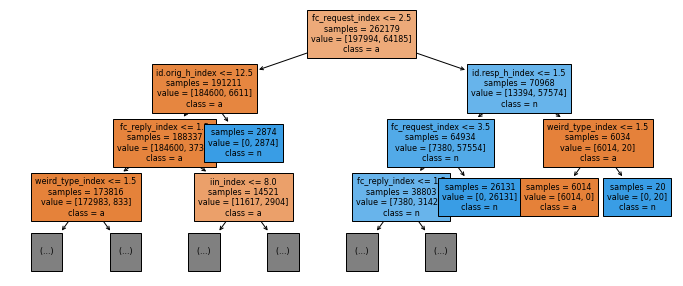

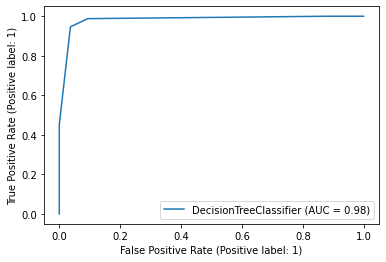

In [ ]:
                                    # ENTRENAMIENTO Y EVALUACIÓN DEL MODELO 

dnp3_features = dnp3_df.drop(['anomaly', 'ts', 'uid', 'id.orig_h', 'id.resp_h', 
                           'fc_request', 'fc_reply', 'weird_type', 'iin', 
                           'id.resp_p', 'id.orig_p'], axis=1)

# Divide the Dataframe between "dnp3_train" and "dnp3_test"
dnp3_train, dnp3_test = train_test_split(dnp3_df, test_size=0.3, shuffle=True)

# Dividir los conjuntos de datos anteriores en X_train y_Train y en X_Test y_test
# X_train, y_train
X_train = dnp3_train.drop(['anomaly', 'ts', 'uid', 'id.orig_h', 'id.resp_h', 
                           'fc_request','fc_reply', 'weird_type', 'iin', 
                           'id.resp_p', 'id.orig_p'], axis=1)
y_train = dnp3_train['anomaly']

# X_test, y_test
X_test = dnp3_test.drop(['anomaly', 'ts', 'uid', 'id.orig_h', 'id.resp_h', 
                           'fc_request', 'fc_reply', 'weird_type', 'iin', 
                           'id.resp_p', 'id.orig_p'], axis=1)
y_test = dnp3_test['anomaly']


# Ahora tenemos que declarar nuestro clasificador "dt" que consisitirá en nuestro árbol de decisión
dt = DecisionTreeClassifier()

# Entrenamos nuesto arbol de decision
dt = dt.fit(X_train, y_train)

# Generamos nuestro y_pred
y_pred = dt.predict(X_test)

# Podemos representar visualmente el arbol que ha generado nuestro modelo. 
#Esto nos resultará muy útil para evaluar las características más importantes

fig, ax = plt.subplots(figsize=(12, 5))

plot = plot_tree(
            decision_tree = dt,
            feature_names = dnp3_features.columns,
            class_names   = 'anomaly',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            precision     = 2,
            ax            = ax, 
            max_depth     = 3
       )


# CALCULO DE MÉTRICAS OBJETIVAS 
# Tasa de Aciertos
acc = metrics.accuracy_score(y_test, y_pred)
# Puntuación f1
f1 = metrics.f1_score(y_test, y_pred, average='binary')

# Siempre antes de empezar a calcular las metricas del modelo, es importante obtener la matriz de confusión y entender cada valor

# Matriz de Confusión
confmat = metrics.confusion_matrix(y_test, y_pred)

# Calcular la tasa de Falsos positivos te permite conocer el porcentaje the instancias negativas se clasifica incorrectamente.
# Esta medida es muy últil a la hora de calcular la curva ROC.
fpr = (confmat[0,1]) / (confmat[0,1] + confmat[0,0])


# Curva ROC. Nos permite observar la comparación entre la Tasa de verdaderos positivos y falsos positivos
metrics.plot_roc_curve(dt, X_test, y_test)
auroc = metrics.roc_auc_score(y_test, y_pred)

>1, train: 0.924, test: 0.924
>2, train: 0.958, test: 0.957
>3, train: 0.958, test: 0.957
>4, train: 0.959, test: 0.959
>5, train: 0.959, test: 0.959
>6, train: 0.959, test: 0.959
>7, train: 0.959, test: 0.959
>8, train: 0.959, test: 0.959
>9, train: 0.959, test: 0.959


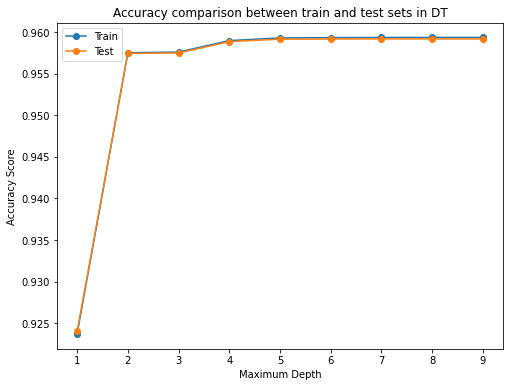

In [ ]:
                                            # Evaluar "Overfitting" del Modelo

from matplotlib import pyplot
# Declarar lists para guardar los valores de accuracy
train_scores, test_scores = list(), list()
values = [i for i in range(1, 10)]
# El objetivo es crear un modelo por cada nivel de profundidad para observar su comportamiento
for i in values:
    # Creación del modelo
    model = DecisionTreeClassifier(max_depth=i)
    # Inyectar el conjunto de train para entrenar el modelo
    model.fit(X_train, y_train)
    
    # Evaluación  train dataset
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    # Evaluación test dataset
    test_yhat = model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # Visualizar Resultados
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    
# Crear un histograma con la evolución
pyplot.figure(figsize=(8, 6))
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.title('Accuracy comparison between train and test sets in DT')
pyplot.xlabel("Maximum Depth")
pyplot.ylabel("Accuracy Score")
pyplot.legend()
pyplot.show()

Feature: id.orig_h_index, Score: 0.070
Feature: id.resp_h_index, Score: 0.109
Feature: fc_request_index, Score: 0.801
Feature: fc_reply_index, Score: 0.016
Feature: weird_type_index, Score: 0.001
Feature: iin_index, Score: 0.003


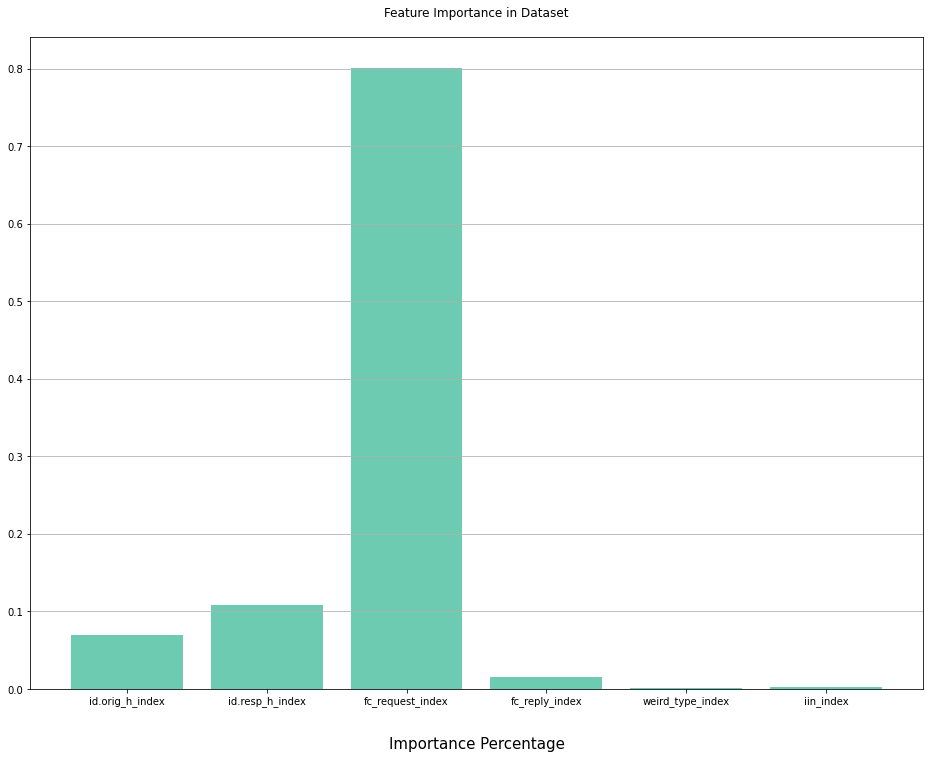

Profundidad del árbol: 7
Número de nodos terminales: 23



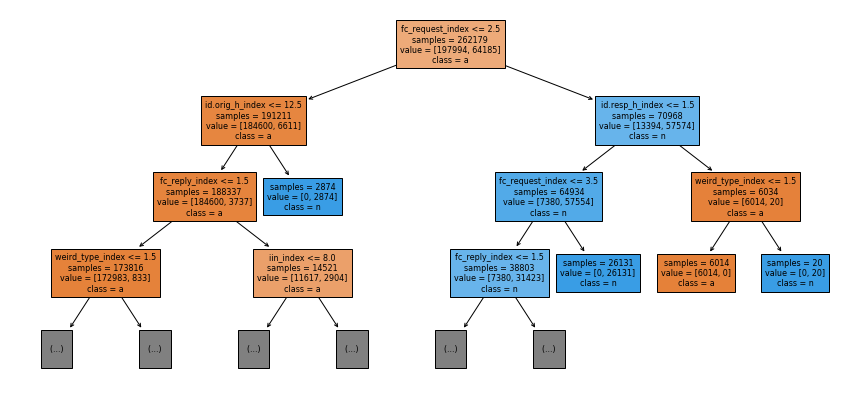

In [ ]:
from matplotlib import pyplot

# Obtener importance
importance = dt.feature_importances_

labels=['id.orig_h_index','id.resp_h_index','fc_request_index','fc_reply_index',
      'weird_type_index', 'iin_index']
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {dnp3_features.columns[i]}, Score: %.3f' % (v))
    # plot feature importance
    pyplot.bar(dnp3_features.columns[i], v, color='#6ccbb0')

plt.xlabel("Importance Percentage", labelpad=30)
plt.rc('axes', labelsize=15) 
plt.title('Feature Importance in Dataset', pad=20)
pyplot.rcParams["figure.figsize"] = (16,12)
plt.grid(axis = 'y')
pyplot.show()

# Podemos representar visualmente el arbol que ha generado nuestro modelo. 
# Esto nos resultará muy útil para evaluar las características más importantes

fig, ax = plt.subplots(figsize=(15, 7))


print(f"Profundidad del árbol: {dt.get_depth()}")
print(f"Número de nodos terminales: {dt.get_n_leaves()}\n")

plot = plot_tree(
            decision_tree = dt,
            feature_names = dnp3_features.columns,
            class_names   = 'anomaly',
            filled        = True,
            impurity      = False,
            fontsize      = 8,
            precision     = 2,
            ax            = ax, 
            max_depth     = 3
       )

In [ ]:
# Mostrar Métricas obtenidas
print(f"Matriz de Confusión:\n{confmat}\n")
print(f"Tasa de Aciertos Conjunto Test: {acc:.3f}\n")
print(f"Puntuación F1: {f1:.3f}\n")
print(f"Tasa de Falsos Positivos: {(confmat[1,0]) / (confmat[1,0] + confmat[0,0]):.3f}\n")
print(f"Precision: {metrics.precision_score(y_test, y_pred):.3f}")
print(f"AUC: {auroc:.2f}\n")
print(f"Recall: {metrics.recall_score(y_test, y_pred):.3f}\n")
confmat[0,1]

Matriz de Confusión:
[[82181  3117]
 [ 1470 25595]]

Tasa de Aciertos Conjunto Test: 0.959

Puntuación F1: 0.918

Tasa de Falsos Positivos: 0.018

Precision: 0.891
AUC: 0.95

Recall: 0.946



3117

## TEST UNDERFITTING

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

X = dnp3_features
y = dnp3_df['anomaly']
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

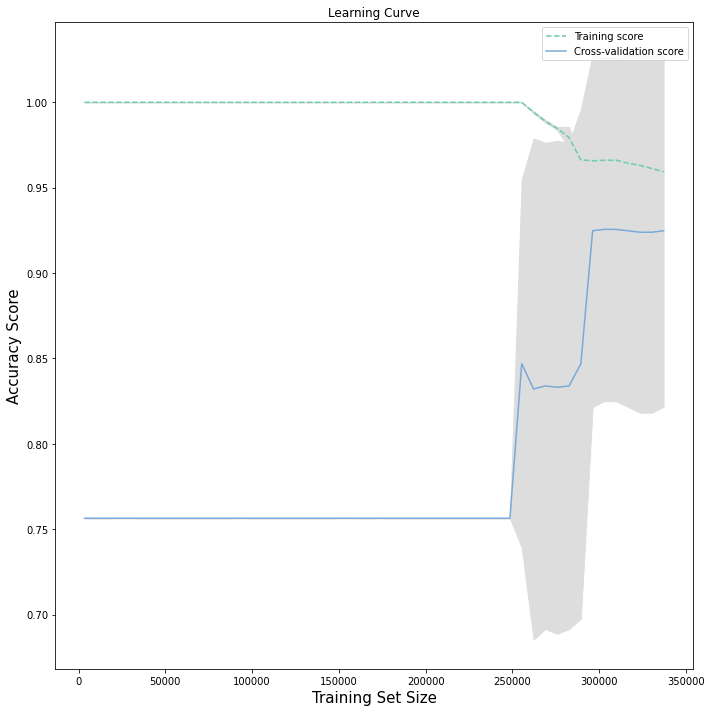

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#6ccbb0",  label="Training score")
plt.plot(train_sizes, test_mean, color="#78a9d8", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Find Best K for KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
error_rate=[]#list that will store the average error rate value of k
for i in range (1,31):  #Took the range of k from 1 to 30
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    predict_i = clf.predict(X_test)
    error_rate.append(np.mean(predict_i != y_test))
error_rate

[0.041321431432055036,
 0.04085864563957887,
 0.04085864563957887,
 0.04085864563957887,
 0.040849745912800474,
 0.04084084618602209,
 0.040849745912800474,
 0.04087644509313564,
 0.04088534481991403,
 0.04088534481991403,
 0.04088534481991403,
 0.04089424454669242,
 0.04089424454669242,
 0.04091204400024919,
 0.04092094372702758,
 0.04092094372702758,
 0.04091204400024919,
 0.04092094372702758,
 0.04091204400024919,
 0.04091204400024919,
 0.04091204400024919,
 0.04092094372702758,
 0.04092094372702758,
 0.04092094372702758,
 0.04092094372702758,
 0.04092094372702758,
 0.04091204400024919,
 0.04091204400024919,
 0.04091204400024919,
 0.04091204400024919]

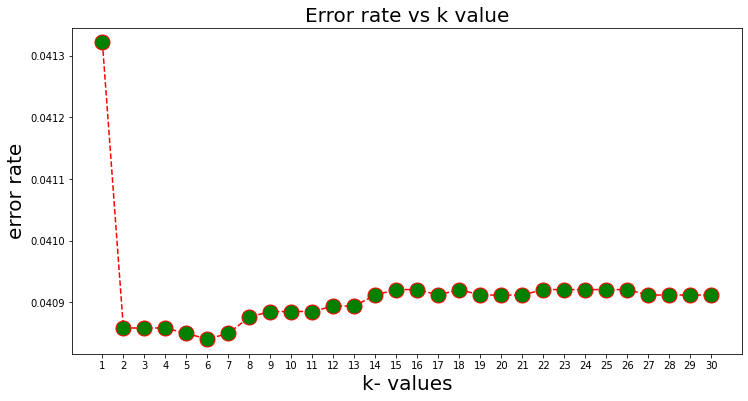

In [ ]:
#plotting the error rate vs k graph 
plt.figure(figsize = (12,6))
plt.plot(range(1,31), error_rate,marker = "o", markerfacecolor="green",
         linestyle = "dashed",color = "red", markersize=15)
plt.title("Error rate vs k value", fontsize = 20)
plt.xlabel("k- values", fontsize = 20)
plt.ylabel("error rate", fontsize = 20)
plt.xticks(range(1, 31))
plt.show()